In [64]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pingouin
import seaborn as sns

wine=load_wine()
n_classes = len(wine['target_names'])
data_shape = wine['data'].shape

w_pd = pd.DataFrame(np.c_[wine['data'], wine['target']], columns=wine['feature_names']+['target'])
w_pd = w_pd.rename(columns={'od280/od315_of_diluted_wines': 'od280/od315'})

X_train, X_test, y_train, y_test = train_test_split(w_pd.iloc[:,:-1], w_pd['target'], test_size=0.3, random_state=42)
print(w_pd)
print(f'Количество классов {n_classes}, форма данных {data_shape}')

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

In [49]:
print(wine['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

## Разведочный анализ

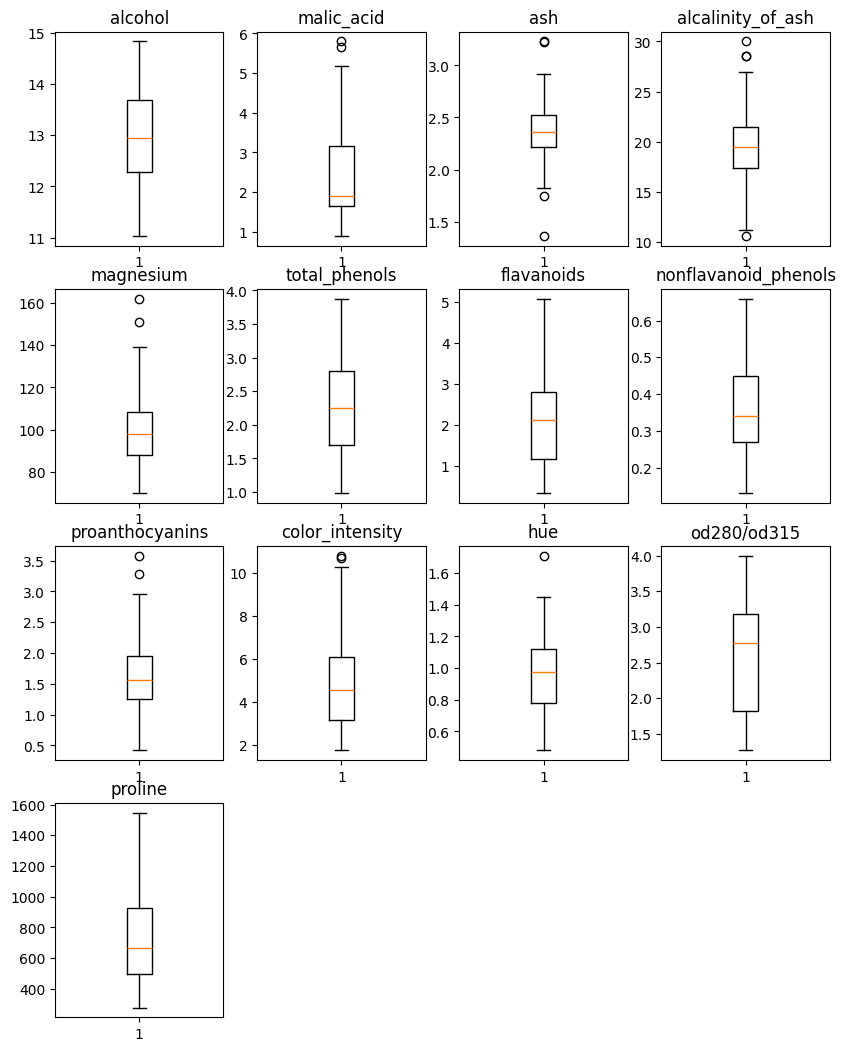

In [65]:
plt.figure(figsize=(10, 12.8))
for i, column in enumerate(X_train.columns):
    plt.subplot(4,4,i+1)
    plt.boxplot(X_train[column])
    plt.title(column)
plt.show()

Многие переменные имеют выбросы, но, их, судя по диаграмме не очень много. Часть диаграмм симметричны и имеют не очень длинные усы. Некоторые же несимметричны или имеют длинные усы.

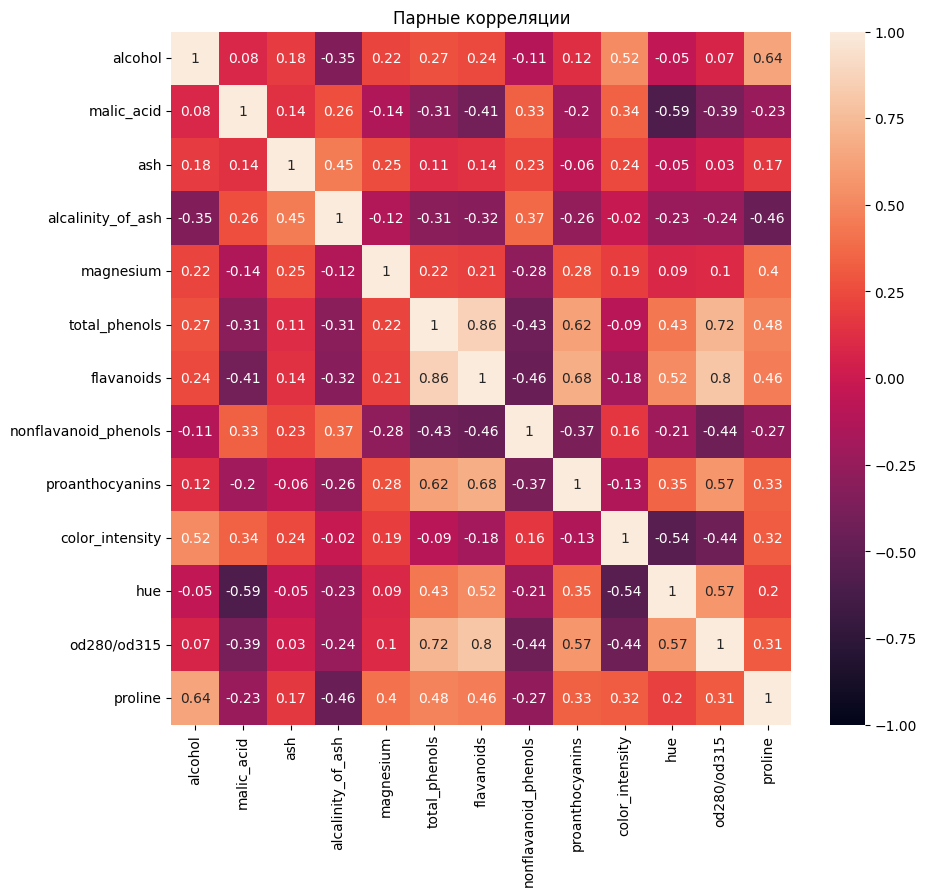

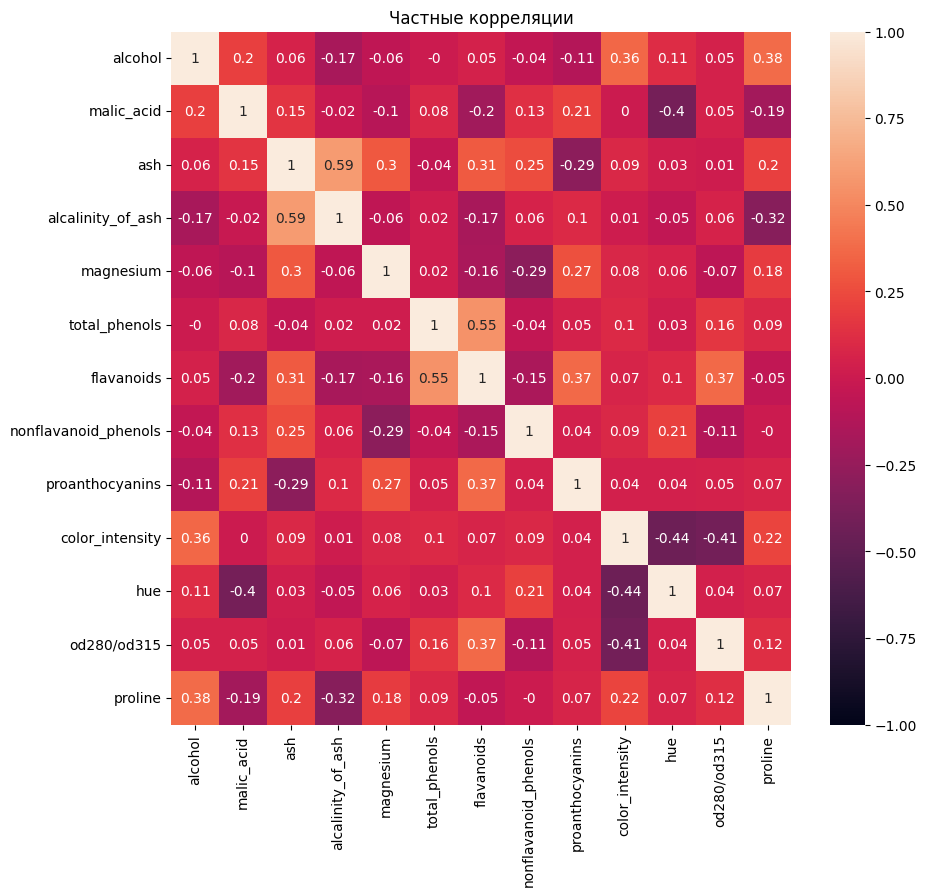

In [66]:
w_corr = X_train.corr()
w_pcorr = X_train.pcorr()
plt.figure(figsize=(10, 9))
sns.heatmap(w_corr.round(2), vmin=-1, vmax=1, annot=True)
plt.title('Парные корреляции')
plt.show()

plt.figure(figsize=(10, 9))
sns.heatmap(w_pcorr.round(2), vmin=-1, vmax=1, annot=True)
plt.title('Частные корреляции')
plt.show()

Некоторые характеристики имеют сильные💪 парные корреляции. Это значит, что можно попробовать предсказывать эти значения через линейную регрессию. Однако, большая часть параметров заметной линейной связи не показывают.

Информативность компонент: [0.36 0.19 0.12 0.08 0.07 0.05 0.04 0.03 0.02 0.02 0.02 0.01 0.01]
Информативность: 66.62%


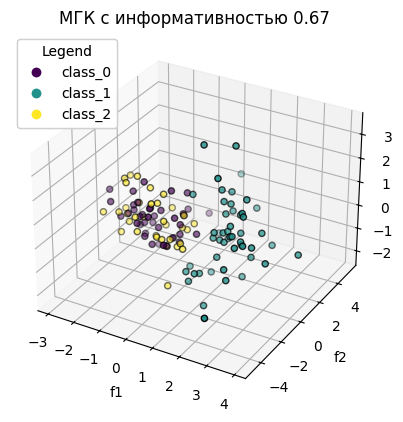

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_train)

pca = PCA()
x_pca = pca.fit_transform(x_scaled, y_train)
data_delta = pca.explained_variance_ratio_
x_pca_pd = pd.DataFrame(x_pca, columns=[ f'f{i}' for i in range(len(X_train.columns))])

print(f'Информативность компонент: {(data_delta).round(2)}')
print(f'Информативность: {100*sum(data_delta[:3]):.2f}%')

def scatter3d(data_pd, columns, classes, classes_names, title=''):
    ax = plt.axes(projection='3d')

    x = data_pd[columns[0]]
    y = data_pd[columns[1]]
    z = data_pd[columns[2]]

    scatter1 = ax.scatter(x, y, z, c=classes, marker='o', edgecolors=['000']*len(x))
    legend1 = ax.legend(*[scatter1.legend_elements()[0],classes_names], 
                        title="Legend", loc='upper left')
    ax.add_artist(legend1)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])
    plt.title(title)
    plt.show()

scatter3d(x_pca_pd, columns=['f1','f2','f3'], classes=y_train, classes_names=wine['target_names'], title=f'МГК с информативностью {sum(data_delta[:3]):.2f}')

Полученное представление имеет не слишком большую информативность (окло 67%), но по ней всё равно можно сделать некоторые выводы, учитывая то, что она показывает не всю информацию о выборке. Так, здесь видно, что первый класс довольно хорошо должен отделяться от двух других, по скольку он находится в отдельном кластере. Также, по картинке можно предположить, что первый класс является линейно отделимым. Для задачи кластеризации видно два кластера.

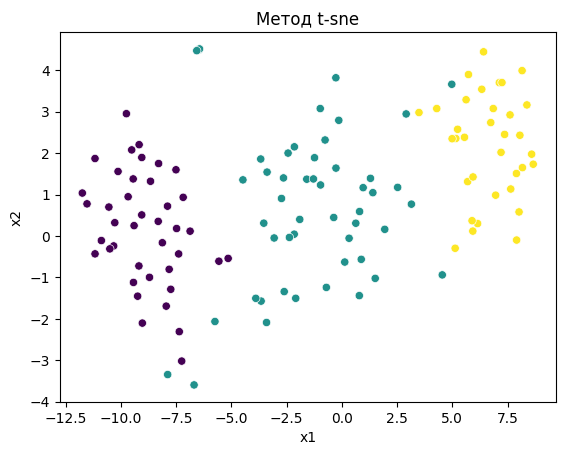

In [107]:
from sklearn.manifold import TSNE

t_sne = TSNE()
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(x_scaled)
tsne_data =pd.DataFrame(tsne_data,columns=['x1','x2'])
sns.scatterplot(data=tsne_data, x='x1', y='x2', c=y_train)
plt.title('Метод t-sne')
plt.legend()
plt.show()

В данном методе видно, что 3 класса довольно хорошо визуально разделимы. Значит, их классификация должна быть возможна и, при этом, с довольно большой хорошей разделимостью. Также на данном представлении видно 3 кластера, которые явно могут быть выделены.

## Прогнозирование

In [ ]:
from sklearn import linear_model
#Прогнозируем hue, flavanoids
l_reg = linear_model.LinearRegression()
X = X_train.loc[]
